In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [118]:
INTRO_DIR = os.path.abspath('.')
DATA_DIR = os.path.join(INTRO_DIR, 'data')

In [119]:
df = pd.read_parquet(os.path.join(DATA_DIR, 'fhv_tripdata_2021-01.parquet'))
df.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


## Q1. Downloading the data

We'll use [the same NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page),
but instead of "Green Taxi Trip Records", we'll use "For-Hire Vehicle Trip Records".

Download the data for January and February 2021.

Note that you need "For-Hire Vehicle Trip Records", not "High Volume For-Hire Vehicle Trip Records".

Read the data for January. How many records are there?

* 1054112
* **1154112**
* 1254112
* 1354112

In [120]:
df['pickup_datetime'].count()

1154112

## Q2. Computing duration

Now let's compute the `duration` variable. It should contain the duration of a ride in minutes. 

What's the average trip duration in January?

* 15.16
* **19.16**
* 24.16
* 29.16

In [121]:
df = df.loc[df['pickup_datetime'].dt.month == 1]
df['duration'] = df['dropOff_datetime'] - df['pickup_datetime']
df['duration'] = df['duration'].apply(lambda td: td.total_seconds() / 60)
df['duration'].mean()

19.167224093791006

## Data preparation

Check the distribution of the duration variable. There are some outliers. 

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop? 

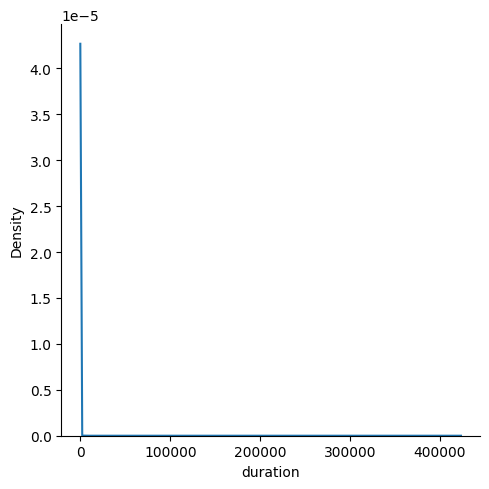

In [122]:
sns.displot(df, x="duration", kind='kde');

In [123]:
before = df.shape[0]

In [124]:
df = df.loc[(df['duration'] >= 1) & (df['duration'] <= 60)]

In [125]:
after = df.shape[0]
print(before - after)

44286


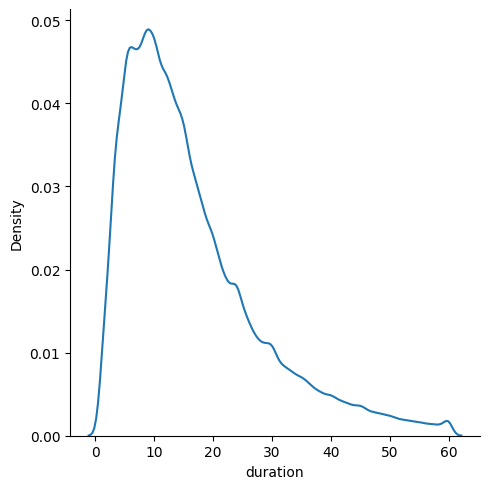

In [126]:
sns.displot(df, x="duration", kind='kde');

## Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs. 

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

* 53%
* 63%
* 73%
* **83%**

In [127]:
df = df[['PUlocationID', 'DOlocationID', 'duration']]

df[['PUlocationID',	'DOlocationID']] = df[['PUlocationID', 'DOlocationID']].fillna(-1)

In [128]:
(df.loc[df['PUlocationID'] == -1, 'PUlocationID'].count() / df['PUlocationID'].count()) * 100

83.52732770722618

## Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model. 

* Turn the dataframe into a list of dictionaries
* Fit a dictionary vectorizer 
* Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

* 2
* 152
* 352
* **525**
* 725

In [129]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109826 entries, 0 to 1154111
Data columns (total 3 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   PUlocationID  1109826 non-null  object 
 1   DOlocationID  1109826 non-null  object 
 2   duration      1109826 non-null  float64
dtypes: float64(1), object(2)
memory usage: 66.1+ MB


In [130]:
train_dicts = df[categorical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [131]:
X_train.shape

(1109826, 525)

## Q5. Training a model

Now let's use the feature matrix from the previous step to train a model. 

* Train a plain linear regression model with default parameters 
* Calculate the RMSE of the model on the training data

What's the RMSE on train?

* 5.52
* **10.52**
* 15.52
* 20.52

In [132]:
target = 'duration'
y_train = df[target].values
y_train

array([17.        , 17.        ,  8.28333333, ..., 16.2       ,
       19.43333333, 36.        ])

In [133]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

10.52851938944385

## Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021). 

What's the RMSE on validation?

* 6.01
* 11.01
* 16.01
* 21.01

In [140]:
df_test = pd.read_parquet(os.path.join(DATA_DIR, 'fhv_tripdata_2021-02.parquet'))

In [141]:
df_test['duration'] = df_test['dropOff_datetime'] - df_test['pickup_datetime']
df_test['duration'] = df_test['duration'].dt.total_seconds() / 60
df_test = df_test.loc[(df_test['duration'] >= 1) & (df_test['duration'] <= 60)]

In [142]:
categorical = ['PUlocationID', 'DOlocationID']
df_test[categorical] = df[categorical].fillna(-1).astype('str')

In [143]:
test_dicts = df_test[categorical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [144]:
target = 'duration'
y_test = df_test[target].values

y_pred = model.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

12.923582312082024